In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [4]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
from torchvision import datasets
from torchvision import transforms

data_path = "../lesson3/dataset"
# cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
# cifar10 = datasets.CIFAR10(data_path, train=False, download=True)
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [7]:
import torch.nn as nn

n_out = 2
model = nn.Sequential(nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, n_out))

In [8]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [9]:
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [10]:
softmax(x).sum()

tensor(1.)

In [15]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1.0, 2.0, 3.0], [3.0, 4.0, 5.0]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [16]:
import torch.nn as nn

n_out = 2
model = nn.Sequential(
    nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, n_out), nn.Softmax(dim=1)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


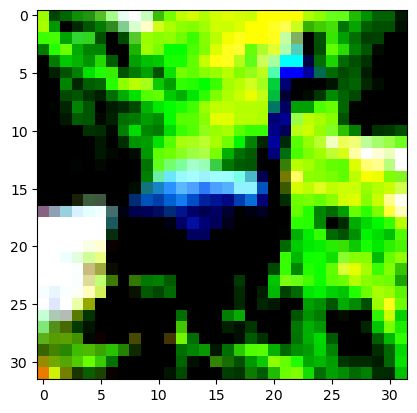

In [18]:
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))

In [21]:
img.shape

torch.Size([3, 32, 32])

img.view(-1): Flattens the tensor.
unsqueeze(0): Adds a batch dimension (resulting in a shape like [1, N], where N is the total number of elements in the original tensor).


In [23]:
img_batch = img.view(-1).unsqueeze(0)
img_batch.shape

torch.Size([1, 3072])

In [27]:
img_batch2 = img.unsqueeze(0)
img_batch2.shape

torch.Size([1, 3, 32, 32])

In [28]:
model(img)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x32 and 3072x512)

In [29]:
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

In [30]:
_, index = torch.max(out, dim=1)
index

tensor([1])

In [37]:
out = torch.tensor(
    [
        [0.6, 0.4],
        [0.9, 0.1],
        [0.3, 0.7],
        [0.2, 0.8],
    ]
)

class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)
class_index
truth = torch.zeros((4, 2))
truth
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [63]:
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
    # y = (out - truth) ** 2
    # print(y)


mse(out)

tensor([[0.1600, 0.1600],
        [0.0100, 0.0100],
        [0.0900, 0.0900],
        [0.0400, 0.0400]])


In [39]:
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [52]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):

        prod *= x

    return prod


likelihood(out)

tensor([0.3024])

In [43]:
def neg_log_likelihood(out):
    return -likelihood(out).log()


neg_log_likelihood(out)

tensor([0.6000])
tensor([0.6000])
tensor([0.9000])
tensor([0.5400])
tensor([0.7000])
tensor([0.3780])
tensor([0.8000])
tensor([0.3024])


tensor([1.1960])

In [46]:
out

tensor([[0.6000, 0.4000],
        [0.9000, 0.1000],
        [0.3000, 0.7000],
        [0.2000, 0.8000]])

In [45]:
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1])
out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6])
out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9])

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison

(tensor([0.0750, 0.1500, 0.2500, 0.4750]),
 tensor([[0.9000, 0.1000],
         [0.9000, 0.1000],
         [0.3000, 0.7000],
         [0.2000, 0.8000]]))

In [49]:
for o in [out0, out, out2, out3]:
    print(o)
    mse(o)
    print(mse(o))

tensor([[0.9000, 0.1000],
        [0.9000, 0.1000],
        [0.3000, 0.7000],
        [0.2000, 0.8000]])
tensor(0.0750)
tensor([[0.6000, 0.4000],
        [0.9000, 0.1000],
        [0.3000, 0.7000],
        [0.2000, 0.8000]])
tensor(0.1500)
tensor([[0.4000, 0.6000],
        [0.9000, 0.1000],
        [0.3000, 0.7000],
        [0.2000, 0.8000]])
tensor(0.2500)
tensor([[0.1000, 0.9000],
        [0.9000, 0.1000],
        [0.3000, 0.7000],
        [0.2000, 0.8000]])
tensor(0.4750)


In [50]:
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [53]:
nll_comparison = torch.tensor([neg_log_likelihood(o) for o in [out0, out, out2, out3]])
nll_comparison

tensor([0.7905, 1.1960, 1.6015, 2.9878])

In [54]:
((nll_comparison / nll_comparison[1]) - 1) * 100

tensor([-33.9016,   0.0000,  33.9016, 149.8121])

In [55]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [56]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

log_softmax(x)

tensor([[-104.,    0.]])

In [57]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [58]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [64]:
model = nn.Sequential(
    nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, 2), nn.LogSoftmax(dim=1)
)
loss = nn.NLLLoss()
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.5077, grad_fn=<NllLossBackward0>)

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim

mdoel = nn.Sequential(
    nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, 2), nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch : %d, LOss : %f" % (epoch, float(loss)))

Epoch : 0, LOss : 4.445263
Epoch : 1, LOss : 4.367403
Epoch : 2, LOss : 5.481987
Epoch : 3, LOss : 3.168825
Epoch : 4, LOss : 12.617499
Epoch : 5, LOss : 6.689180
Epoch : 6, LOss : 9.722066
Epoch : 7, LOss : 4.721662
Epoch : 8, LOss : 5.171774
Epoch : 9, LOss : 10.724582
Epoch : 10, LOss : 7.508717
Epoch : 11, LOss : 6.297767
Epoch : 12, LOss : 8.868284
Epoch : 13, LOss : 13.856395
Epoch : 14, LOss : 10.373698
Epoch : 15, LOss : 9.347772
Epoch : 16, LOss : 8.073361
Epoch : 17, LOss : 0.508486
Epoch : 18, LOss : 6.389364
Epoch : 19, LOss : 0.365493
Epoch : 20, LOss : 4.525823
Epoch : 21, LOss : 5.434015
Epoch : 22, LOss : 0.480586
Epoch : 23, LOss : 2.973242
Epoch : 24, LOss : 11.725420
Epoch : 25, LOss : 0.180209
Epoch : 26, LOss : 0.093298
Epoch : 27, LOss : 0.973789
Epoch : 28, LOss : 5.838484
Epoch : 29, LOss : 14.743950
Epoch : 30, LOss : 9.641453
Epoch : 31, LOss : 6.851185
Epoch : 32, LOss : 5.883249
Epoch : 33, LOss : 8.782618
Epoch : 34, LOss : 0.629203
Epoch : 35, LOss : 14.06

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
mdoel = nn.Sequential(
    nn.Linear(3072, 128), nn.Tanh(), nn.Linear(128, 2), nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for img, label in train_loader:
        out = model(img.view(img.shape[0], -1))
        loss = loss_fn(out, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch : %d, Loss : %f" % (epoch, float(loss)))

Epoch : 0, Loss : 0.993731
Epoch : 1, Loss : 0.653510
Epoch : 2, Loss : 0.037373
Epoch : 3, Loss : 0.072298
Epoch : 4, Loss : 0.365193
Epoch : 5, Loss : 0.371821
Epoch : 6, Loss : 0.030141
Epoch : 7, Loss : 0.048294
Epoch : 8, Loss : 0.069407
Epoch : 9, Loss : 0.066418
Epoch : 10, Loss : 0.292597
Epoch : 11, Loss : 0.457423
Epoch : 12, Loss : 0.010392
Epoch : 13, Loss : 0.327289
Epoch : 14, Loss : 0.087291
Epoch : 15, Loss : 0.025777
Epoch : 16, Loss : 0.005806
Epoch : 17, Loss : 0.061225
Epoch : 18, Loss : 0.055023
Epoch : 19, Loss : 0.045844
Epoch : 20, Loss : 0.124459
Epoch : 21, Loss : 0.443585
Epoch : 22, Loss : 0.482496
Epoch : 23, Loss : 0.006191
Epoch : 24, Loss : 0.091066
Epoch : 25, Loss : 0.044534
Epoch : 26, Loss : 0.377320
Epoch : 27, Loss : 0.088943
Epoch : 28, Loss : 0.036286
Epoch : 29, Loss : 0.108661
Epoch : 30, Loss : 0.244442
Epoch : 31, Loss : 0.152405
Epoch : 32, Loss : 0.108267
Epoch : 33, Loss : 0.215112
Epoch : 34, Loss : 0.189628
Epoch : 35, Loss : 0.748387
Ep

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
mdoel = nn.Sequential(
    nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, 2), nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for img, label in train_loader:
        out = model(img.view(img.shape[0], -1))
        loss = loss_fn(out, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch : %d, Loss : %f" % (epoch, float(loss)))

Epoch : 0, Loss : 0.174268
Epoch : 1, Loss : 0.136959
Epoch : 2, Loss : 0.004313
Epoch : 3, Loss : 0.326512
Epoch : 4, Loss : 0.421827
Epoch : 5, Loss : 0.150288
Epoch : 6, Loss : 0.022458
Epoch : 7, Loss : 0.241371
Epoch : 8, Loss : 0.092438
Epoch : 9, Loss : 0.191329
Epoch : 10, Loss : 0.147624
Epoch : 11, Loss : 0.017155
Epoch : 12, Loss : 0.005376
Epoch : 13, Loss : 0.009239
Epoch : 14, Loss : 0.019962
Epoch : 15, Loss : 0.195628
Epoch : 16, Loss : 0.028694
Epoch : 17, Loss : 0.015584
Epoch : 18, Loss : 0.148816
Epoch : 19, Loss : 0.108175
Epoch : 20, Loss : 0.137405
Epoch : 21, Loss : 0.082982
Epoch : 22, Loss : 0.024785
Epoch : 23, Loss : 0.122263
Epoch : 24, Loss : 0.092117
Epoch : 25, Loss : 0.149515
Epoch : 26, Loss : 0.187000
Epoch : 27, Loss : 0.189935
Epoch : 28, Loss : 0.026156
Epoch : 29, Loss : 0.064289
Epoch : 30, Loss : 0.059273
Epoch : 31, Loss : 0.443261
Epoch : 32, Loss : 0.002924
Epoch : 33, Loss : 0.016522
Epoch : 34, Loss : 0.168449
Epoch : 35, Loss : 0.270583
Ep

In [73]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        print(total, labels)
        correct += int((predicted == labels).sum())
print("Accuracy: %f" % (correct / total))

64 tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0])
128 tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0])
192 tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0])
256 tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0])
320 tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1

In [74]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 0.748500


In [75]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.410539
Epoch: 1, Loss: 0.607154
Epoch: 2, Loss: 0.474970
Epoch: 3, Loss: 0.485383
Epoch: 4, Loss: 0.321286
Epoch: 5, Loss: 0.182294
Epoch: 6, Loss: 0.323795
Epoch: 7, Loss: 0.327945
Epoch: 8, Loss: 0.784662
Epoch: 9, Loss: 0.255426
Epoch: 10, Loss: 0.422364
Epoch: 11, Loss: 0.667554
Epoch: 12, Loss: 0.401560
Epoch: 13, Loss: 0.549555
Epoch: 14, Loss: 0.805928
Epoch: 15, Loss: 0.282594
Epoch: 16, Loss: 0.342534
Epoch: 17, Loss: 0.150693
Epoch: 18, Loss: 0.436469
Epoch: 19, Loss: 0.286100
Epoch: 20, Loss: 0.198358
Epoch: 21, Loss: 0.454082
Epoch: 22, Loss: 0.183760
Epoch: 23, Loss: 0.126981
Epoch: 24, Loss: 0.514936
Epoch: 25, Loss: 0.259356
Epoch: 26, Loss: 0.391230
Epoch: 27, Loss: 0.294232
Epoch: 28, Loss: 0.454814
Epoch: 29, Loss: 0.257044
Epoch: 30, Loss: 0.319317
Epoch: 31, Loss: 0.169349
Epoch: 32, Loss: 0.408393
Epoch: 33, Loss: 0.151755
Epoch: 34, Loss: 0.189955
Epoch: 35, Loss: 0.102435
Epoch: 36, Loss: 0.165404
Epoch: 37, Loss: 0.469103
Epoch: 38, Loss: 0.225

In [76]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 1.000000


In [77]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 0.800500


In [78]:
sum([p.numel() for p in model.parameters()])

3737474

In [79]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

In [80]:
linear = nn.Linear(3072, 1024)
linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [81]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [82]:
conv.bias.shape

torch.Size([16])

In [117]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))

In [118]:
img.unsqueeze(0)

tensor([[[[ 0.6139, -0.3228,  ..., -0.2752, -0.5451],
          [ 0.6615, -0.1482,  ..., -0.3228, -0.5768],
          ...,
          [ 0.5980,  0.4393,  ..., -0.4340,  0.0265],
          [ 0.9156,  0.8044,  ..., -0.5451, -0.0529]],

         [[ 1.3369,  0.2740,  ...,  0.3867,  0.0968],
          [ 1.4497,  0.5961,  ...,  0.3062,  0.0646],
          ...,
          [ 0.5478,  0.6605,  ...,  0.4028,  0.8860],
          [ 0.4834,  0.9504,  ...,  0.1613,  0.7572]],

         [[-0.4487, -0.7935,  ..., -0.6736, -0.8535],
          [-0.4487, -0.9734,  ..., -0.6286, -0.8535],
          ...,
          [-0.4337, -0.4787,  ..., -1.3032, -0.9884],
          [-0.1789,  0.0310,  ..., -1.3182, -1.0484]]]])

In [119]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


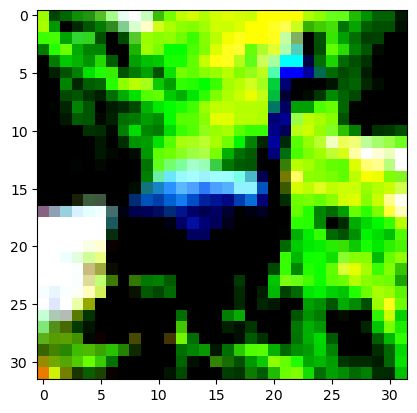

In [87]:
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()

detach():
This removes the tensor from the computational graph (used in PyTorch), meaning the tensor is no longer connected to the computation of gradients. This is necessary if output is the result of a forward pass in a neural network and you're only interested in displaying the image without computing further gradients.


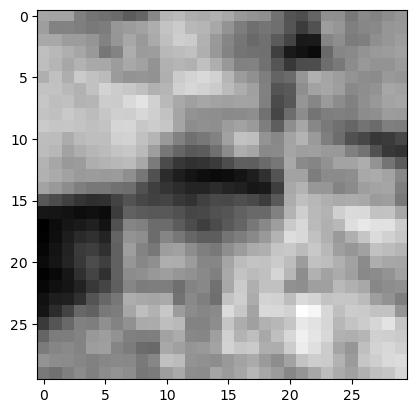

In [88]:
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

In [89]:
out.shape

torch.Size([16, 2])

In [90]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))

output.shape

torch.Size([1, 1, 32, 32])

In [91]:
with torch.no_grad():
    conv.bias.zero_()

In [92]:
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

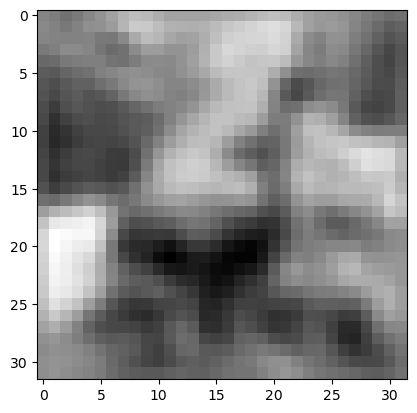

In [93]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

In [94]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor(
        [[-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0]]
    )
    conv.bias.zero_()

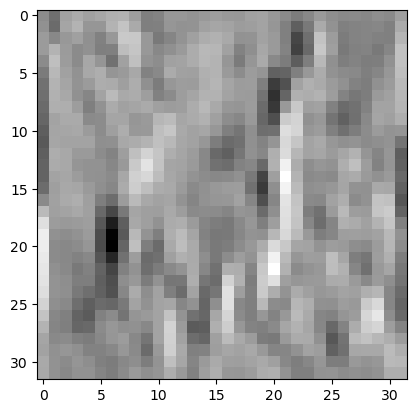

In [95]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

In [96]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

output.shape

torch.Size([1, 3, 16, 16])

In [98]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
)

In [123]:
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Layer 1
    nn.Tanh(),  # Activation 1
    nn.MaxPool2d(2),  # Pooling 1
    nn.Conv2d(16, 8, kernel_size=3, padding=1),  # Layer 2
    nn.Tanh(),  # Activation 2
    nn.MaxPool2d(2),  # Pooling 2
    nn.Flatten(),  # Flatten layer (Added)
    nn.Linear(512, 32),  # Fully Connected Layer 1
    nn.Tanh(),  # Activation 4
    nn.Linear(32, 2),  # Fully Connected Layer 2
)

In [103]:
sum([p.numel() for p in model.parameters()])

18090

In [124]:
model(img.unsqueeze(0))

tensor([[ 0.1153, -0.0079]], grad_fn=<AddmmBackward0>)